In [1]:
from Model3 import RiverDeltaModel
import matplotlib.pyplot as plt
import networkx as nx
import warnings 
import copy
import matplotlib.lines as mlines

c:\Users\sjuul\anaconda3\envs\afstuderen2025\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
warnings.simplefilter("ignore")

model = RiverDeltaModel()

initial_model_state = copy.deepcopy(model) 
for j in range(300):
    model.step()

There are 0 agents unassigned!!
77700689.26849046
11947650.30981201
10810133.368884392
11562189.356544755
21201883.00993447
63610391.06800878
100518533.13017637
28186919.691230804
10847808.930622377
16675301.280731257
39294689.24693945
40536273.54535599
31920108.89377205
20432269.63876156
212744871.9592816
28421010.545189634
71002208.45807773
13805988.463644639
36088078.316358656
16773105.167836033
10927571.253852293
26328737.6586421
17896711.521293223
107819740.01631719
24493634.864613645
20073889.719398916
64442047.83878666
24364191.604565598
83358183.17493282
12813212.6239901
81488875.80009067
12081940.730280261
22619069.923790872
53075499.07131159
120509715.42114088
20500358.168365054
137365541.88325143
25861297.721728265
14563452.856364429
15069173.798962109
13242659.616391659
13880507.657502368
14059961.631054092
29959215.205993623
84317746.5812735
48690641.03721166
17058296.64292481
22164786.947449163
14735951.677699827
43155703.3031557
12805653.93778184
90913044.53681453
624871

In [3]:
model_data = model.datacollector.get_model_vars_dataframe()
model_data

,Average_Livelihood
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


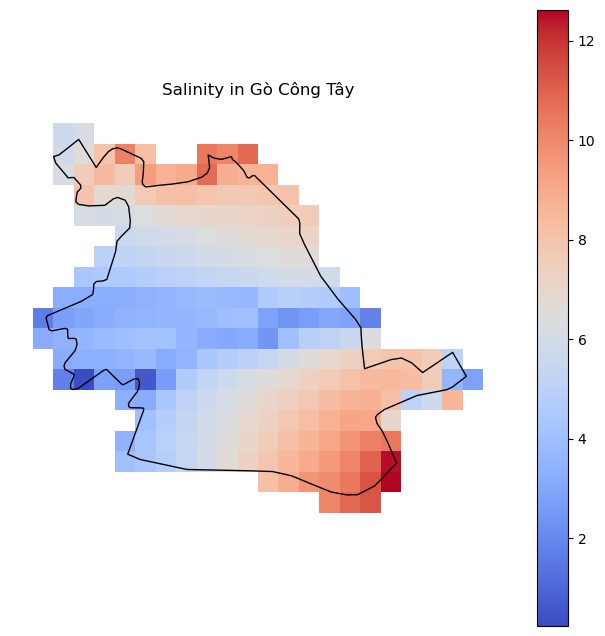

In [4]:
fig, ax = plt.subplots(figsize=(8, 8))
model.polygon_districts.boundary.plot(ax=ax, color='black', linewidth=1)
model.data_salinity.plot(ax=ax, column="Salinity", cmap="coolwarm", legend=True)
plt.title(f"Salinity in {model.district}")
plt.axis("off")
plt.show()

145
123


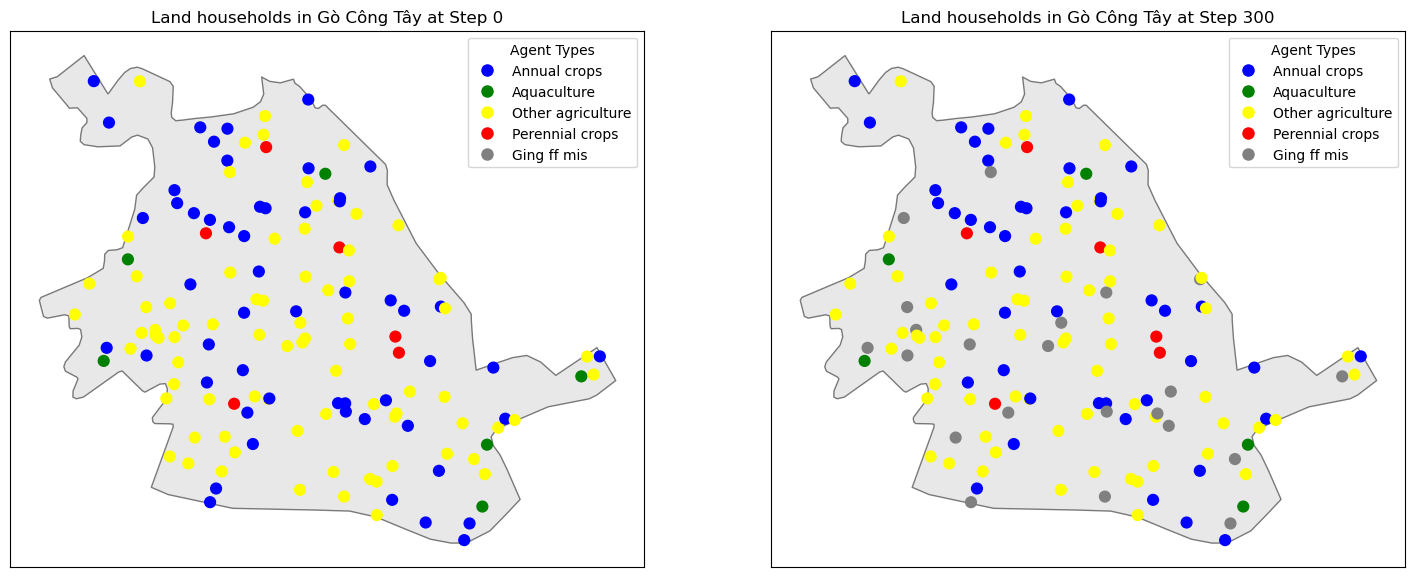

In [5]:
from Model3 import Large_land_households, Middle_land_households, Small_land_households

def plot_network(ax, model):
    ax.clear()

    # Plot district map
    model.polygon_districts.plot(ax=ax, facecolor="lightgray", edgecolor="black", alpha=0.5)

    # Get node positions
    pos = nx.get_node_attributes(model.G, 'pos')

    # Map node_id to agent
    node_to_agent = {
        agent.node_id: agent
        for agent in model.agents
        if isinstance(agent, (Large_land_households, Middle_land_households, Small_land_households))
    }
    print(len(node_to_agent))
    # Prepare lists for nodes and their colors
    nodes_to_draw = []
    colors_to_draw = []

    for node_id in model.G.nodes():
        nodes_to_draw.append(node_id)
        agent = node_to_agent.get(node_id)
        if agent:
            if agent.crop_type == "Annual crops":
                colors_to_draw.append('blue')
            elif agent.crop_type == "Aquaculture":
                colors_to_draw.append('green')
            elif agent.crop_type == "Other agriculture":
                colors_to_draw.append('yellow')
            elif agent.crop_type == "Perennial crops":
                colors_to_draw.append('red')
            else:
                colors_to_draw.append("gray")  # unknown crop
        else:
            colors_to_draw.append("gray")  # migrated / no agent

    # Draw edges first (optional)
    #nx.draw_networkx_edges(model.G, pos, ax=ax, edge_color="gray")

    # Draw nodes with matching colors
    nx.draw_networkx_nodes(model.G, pos,
                           nodelist=nodes_to_draw,
                           node_color=colors_to_draw,
                           node_size=60,
                           ax=ax)

    # Add legend
    blue_patch = mlines.Line2D([], [], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Annual crops')
    green_patch = mlines.Line2D([], [], marker='o', color='w', markerfacecolor='green', markersize=10, label='Aquaculture')
    yellow_patch = mlines.Line2D([], [], marker='o', color='w', markerfacecolor='yellow', markersize=10, label='Other agriculture')
    red_patch = mlines.Line2D([], [], marker='o', color='w', markerfacecolor='red', markersize=10, label='Perennial crops')
    grey_patch = mlines.Line2D([], [], marker='o', color='w', markerfacecolor='gray', markersize=10, label='Ging ff mis')
    ax.legend(handles=[blue_patch, green_patch, yellow_patch, red_patch, grey_patch], loc='upper right', title='Agent Types')

    ax.set_title(f"Land households in {model.district} at Step {model.steps}", fontsize=12)

    # Call function above to plot the map
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18, 9))
plot_network(ax1, initial_model_state)
plot_network(ax2, model)
plt.show()
